In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import xlrd


Welcome to JupyROOT 6.20/04


In [2]:
sg_file = uproot.open("/data/event/final/sg_30ppwax/Events/run_01/tag_1_delphes_events.root") 
bg_file = uproot.open("/data/event/final/bg_ppaalvll/Events/run_01/tag_1_delphes_events.root")
m_ax = 30
bg_Xsection = 94.37
sg_Xsection = 10220   #fb = pb*1000

# bg_x : 94.37
# sg_x : 100(4584) 90(5059) 80(5583) 70(6252) 65(6640) 60(6998) 50(7858) 40(8969) 30(10220) |25(10890)

In [3]:
def file_np(file):
    event = [ file["Delphes;1"]["Electron"].array(),
              file["Delphes;1"]["Electron.PT"].array(),
              file["Delphes;1"]["Electron.Eta"].array(),
              file["Delphes;1"]["Electron.Phi"].array(),
              file["Delphes;1"]["Muon"].array(),                #4
              file["Delphes;1"]["Muon.PT"].array(),
              file["Delphes;1"]["Muon.Eta"].array(),
              file["Delphes;1"]["Muon.Phi"].array(),
              file["Delphes;1"]["Photon"].array(),              #8
              file["Delphes;1"]["Photon.PT"].array(),
              file["Delphes;1"]["Photon.Eta"].array(),
              file["Delphes;1"]["Photon.Phi"].array(),
              file["Delphes;1"]["MissingET"].array(),           #12
              file["Delphes;1"]["MissingET.fUniqueID"].array(),   
              file["Delphes;1"]["MissingET.fBits"].array(),
              file["Delphes;1"]["MissingET.MET"].array(),
              file["Delphes;1"]["MissingET.Eta"].array(),
              file["Delphes;1"]["MissingET.Phi"].array(),
              file["Delphes;1"]["Jet"].array(),                 #18
              file["Delphes;1"]["Jet.EhadOverEem"].array(),     
              file["Delphes;1"]["Jet.Mass"].array(),
              file["Delphes;1"]["Event.Number"].array(),
              file["Delphes;1"]["Jet.Tau[5]"].array(),
              file["Delphes;1"]["Event.CrossSection"].array()
              ]
    
    event = np.expand_dims(event, axis=-1)    ### reshape data
    event = event.transpose((1,0,2))
    event = np.squeeze(event,axis=(2,))
    return event 
    

In [4]:
bg_events = file_np(bg_file)
sg_events = file_np(sg_file)

In [5]:
me = 0.000511
mu = 0.10566


max_shift = m_ax*0.1
max_u = m_ax + max_shift
max_d = m_ax - max_shift
################################################
def prlen(events):
    print(len(events))

################################################  sel
def num_sl(event,lab,num):
    where1 = np.where(event[:,lab]==num)
    return event[where1]

def l_sl(event):
    where1 = np.where(event[:,0]+event[:,4]==1)
    return event[where1]
       
################################################  maa caculate
def m_aa(events, m, pt1):
    where1=[]   
    for i in range(len(events)):
        p = [0,0,0,0] 
        for j in range(events[i][8]):
            pt = events[i][9][j]   
            eta = events[i][10][j]  
            phi = events[i][11][j]    
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)   ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )     
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pt1.append(pTaa)
        if max_d<maa<max_u:
            where1.append(i)
    return events[where1]
################################################        
def pt_sl(events):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]    
        for j in range(events[i][8]):
            pt = events[i][9][j]    
            eta = events[i][10][j]    
            phi = events[i][11][j]   
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)    
        if pTaa>50:
              where1.append(i)
    return events[where1]
################################################
def mvl_sl(events,m):
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(mlv)
################################################## must 1l events
def MTvl_sl(events,m,pt):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        
        m.append(mlv)
        pt.append(ptlv)
        if mlv > 58:
            where1.append(i)
    return(events[where1])
##################################################   
def PTvl_sl(events,m,pt):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        m.append(mlv)
        pt.append(ptlv)
        if ptlv > 50:
            where1.append(i)
    return(events[where1])
#######################################################################################
def phi_v(events,phi_list):
    for i in range(len(events)):
        if events[i][0]==1:
            for j in range(len(events[i][3])):
                phi = (events[i][2][j])
                phi_list.append(phi)
        elif events[i][4]==1:
            for j in range(len(events[i][7])):
                phi = events[i][6][j]
                phi_list.append(phi)  
                
def miss_v(events,phi_list):
    for i in range(len(events)):
        for j in range(len(events[i][16])):
            phi = (events[i][17][j])
            phi_list.append(phi)
########################################################################################
def significance(s,b):   ### t = (sigma b)^2
    t = (b*0.05)**2
    g = 2*((s+b)*np.log((s+b)*(b+t)/(b**2+(s+b)*t))-((b**2)/t)*np.log(1+(t*s/(b*(b+t)))))
    return np.sqrt(g)

########################################################################################
def z_2(f, left, right, epsilon=1e-12):
    if left >= right:
        return None

    while abs(right - left) > epsilon:
        mid = (left + right) / 2
        f_mid = f(mid,b)-2
        if f_mid == 0:
            return mid
        elif f_mid < 0:
            left = mid
        elif f_mid > 0:
            right = mid

    return (left + right) / 2

sg no sl : 10000
sg after 2aa sl : 2041
sg after 2aa_1l sl : 1210
sg after 2aa_1l_pt sl : 948
sg after 2aa_1l_pt, sl ,MTvl>58 sl : 642
sg after 2aa_1l_pt ,MTvl>58  27.0 <maa< 33.0 sl : 632

bg no sl : 100000
bg after 2aa sl : 40390
bg after 2aa_1l sl : 24564
bg after 2aa_1l_pt sl : 3201
bg after 2aa_1l_pt,MTvl>58 sl : 1559
bg after 2aa_1l_pt,MTvl>58  27.0 <maa< 33.0 sl : 74

sg no sl : 3066000.0
sg after 2aa sl : 625770.6
sg after 2aa_1l sl : 370985.99999999994
sg after 2aa_1l_pt sl : 290656.8
sg after 2aa_1l_pt, sl ,MTvl>58 sl : 196837.19999999998
sg after 2aa_1l_pt ,MTvl>58  27.0 <maa< 33.0 sl : 193771.20000000004

bg no sl : 28311.0
bg after 2aa sl : 11434.812899999999
bg after 2aa_1l sl : 6954.31404
bg after 2aa_1l_pt sl : 906.23511
bg after 2aa_1l_pt,MTvl>58 sl : 441.36848999999995
bg after 2aa_1l_pt,MTvl>58  27.0 <maa< 33.0 sl : 20.95014


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

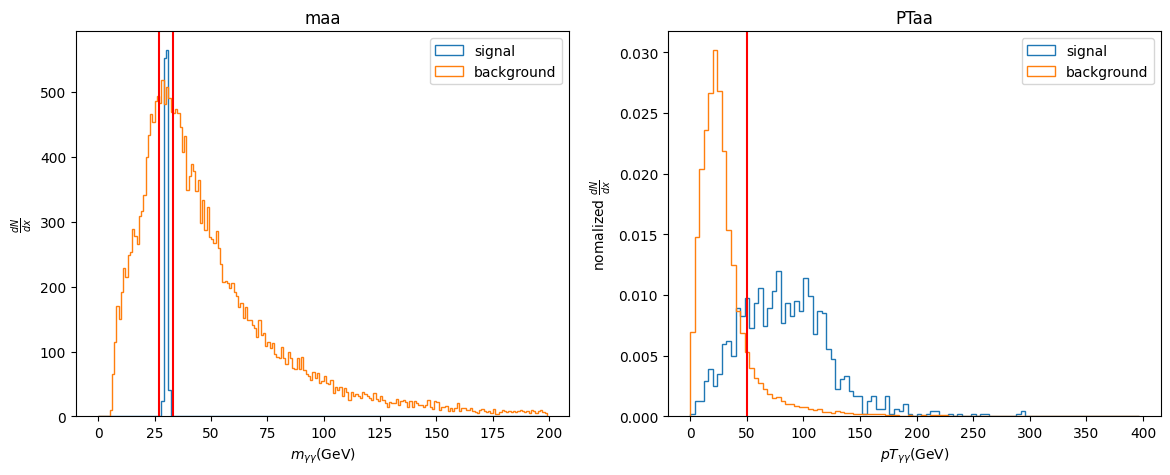

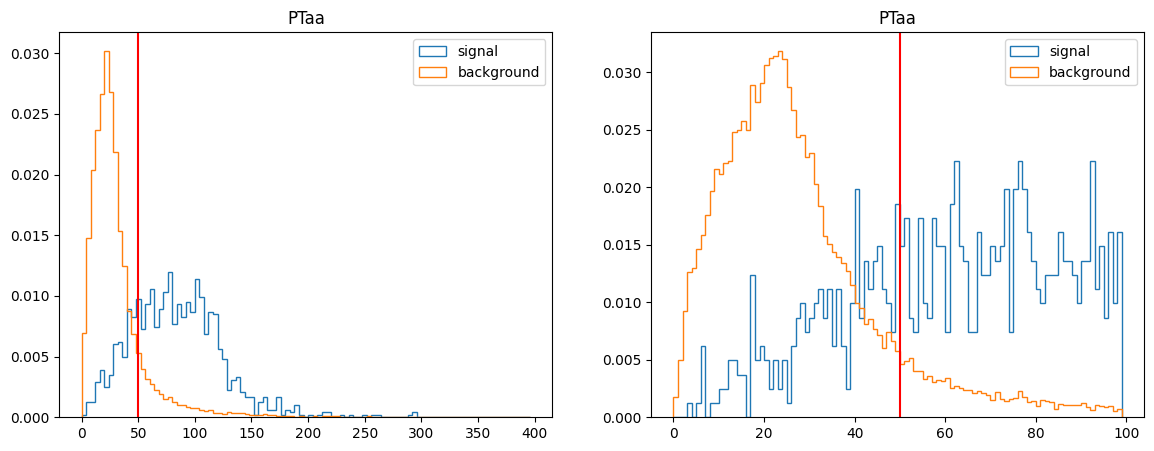

In [12]:
####################################################################################### two_a , 1_l , maa , pt sel
sgsl_2a = num_sl(sg_events,8,2)
sgsl_2a_1l = l_sl(sgsl_2a)
bgsl_2a = num_sl(bg_events,8,2)
bgsl_2a_1l = l_sl(bgsl_2a)
####################### drow picture use
maa_sgsl_2a_1l=[]
pt_sgsl_2a_1l=[]
maa_bgsl_2a_1l=[]
pt_bgsl_2a_1l=[]

################################## maa sl result (drow pic)
sgsl_2a_1l_msl = m_aa(sgsl_2a_1l,maa_sgsl_2a_1l,pt_sgsl_2a_1l)   ###msl   90<max<110
bgsl_2a_1l_msl = m_aa(bgsl_2a_1l,maa_bgsl_2a_1l,pt_bgsl_2a_1l) 

################################## pTaa sl
sgsl_2a_1l_pt = pt_sl(sgsl_2a_1l)
bgsl_2a_1l_pt = pt_sl(bgsl_2a_1l)

############################################################################## PT(lvl) MT(lvl)
MTvlsgsl_2a_1l_pt=[]
MTvlbgsl_2a_1l_pt=[]
PTvlsgsl_2a_1l_pt=[]
PTvlbgsl_2a_1l_pt=[]


sgsl_2a_1l_pt_MTsl = MTvl_sl(sgsl_2a_1l_pt, MTvlsgsl_2a_1l_pt, PTvlsgsl_2a_1l_pt)
bgsl_2a_1l_pt_MTsl = MTvl_sl(bgsl_2a_1l_pt, MTvlbgsl_2a_1l_pt, PTvlbgsl_2a_1l_pt)

##############################################################################
maa_sgsl_2a_1l_pt_MTsl=[]
pt_sgsl_2a_1l_pt_MTsl=[]
maa_bgsl_2a_1l_pt_MTsl=[]
pt_bgsl_2a_1l_pt_MTsl=[]

sgsl_2a_1l_pt_MTsl_msl = m_aa(sgsl_2a_1l_pt_MTsl,maa_sgsl_2a_1l_pt_MTsl,pt_sgsl_2a_1l_pt_MTsl)   # final sl  sgsl_2a_1l_pt_msl
bgsl_2a_1l_pt_MTsl_msl = m_aa(bgsl_2a_1l_pt_MTsl,maa_bgsl_2a_1l_pt_MTsl,pt_bgsl_2a_1l_pt_MTsl)   # final sl  bgsl_2a_1l_pt_msl

##############################################################################
def s300(sgsl_event):
    s = sg_Xsection*(len(sgsl_event)/len(sg_events))*300
    return s

def b300(bgsl_event):
    b = 94.37*(len(bgsl_event)/len(bg_events))*300
    return b



print('\033[0;34msg no sl :\033[0m',len(sg_events))
print('\033[0;34msg after 2aa sl :\033[0m',len(sgsl_2a))
print('\033[0;34msg after 2aa_1l sl :\033[0m',len(sgsl_2a_1l))
print('\033[0;34msg after 2aa_1l_pt sl :\033[0m',len(sgsl_2a_1l_pt))
print('\033[0;34msg after 2aa_1l_pt, sl ,MTvl>58 sl :\033[0m',len(sgsl_2a_1l_pt_MTsl))
print('\033[0;34msg after 2aa_1l_pt ,MTvl>58 ' ,max_d,'<maa<',max_u, 'sl :\033[0m',len(sgsl_2a_1l_pt_MTsl_msl))           
print('')
print('\033[0;33mbg no sl :\033[0m',len(bg_events))
print('\033[0;33mbg after 2aa sl :\033[0m',len(bgsl_2a))
print('\033[0;33mbg after 2aa_1l sl :\033[0m',len(bgsl_2a_1l))
print('\033[0;33mbg after 2aa_1l_pt sl :\033[0m',len(bgsl_2a_1l_pt))
print('\033[0;33mbg after 2aa_1l_pt,MTvl>58 sl :\033[0m',len(bgsl_2a_1l_pt_MTsl))
print('\033[0;33mbg after 2aa_1l_pt,MTvl>58 ' ,max_d,'<maa<',max_u, 'sl :\033[0m',len(bgsl_2a_1l_pt_MTsl_msl))           
print('')
print('\033[0;34msg no sl :\033[0m',s300(sg_events))
print('\033[0;34msg after 2aa sl :\033[0m',s300(sgsl_2a))
print('\033[0;34msg after 2aa_1l sl :\033[0m',s300(sgsl_2a_1l))
print('\033[0;34msg after 2aa_1l_pt sl :\033[0m',s300(sgsl_2a_1l_pt))
print('\033[0;34msg after 2aa_1l_pt, sl ,MTvl>58 sl :\033[0m',s300(sgsl_2a_1l_pt_MTsl))
print('\033[0;34msg after 2aa_1l_pt ,MTvl>58 ' ,max_d,'<maa<',max_u, 'sl :\033[0m',s300(sgsl_2a_1l_pt_MTsl_msl))
print('')
print('\033[0;33mbg no sl :\033[0m',b300(bg_events))
print('\033[0;33mbg after 2aa sl :\033[0m',b300(bgsl_2a))
print('\033[0;33mbg after 2aa_1l sl :\033[0m',b300(bgsl_2a_1l))
print('\033[0;33mbg after 2aa_1l_pt sl :\033[0m',b300(bgsl_2a_1l_pt))
print('\033[0;33mbg after 2aa_1l_pt,MTvl>58 sl :\033[0m',b300(bgsl_2a_1l_pt_MTsl))
print('\033[0;33mbg after 2aa_1l_pt,MTvl>58 ' ,max_d,'<maa<',max_u, 'sl :\033[0m',b300(bgsl_2a_1l_pt_MTsl_msl))   
################################## drow maa pt to decide pt cut

plt.figure(1)
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
bins=np.arange(0,200,1) 
plt.hist(maa_sgsl_2a_1l, bins=bins, label="signal", histtype='step')
plt.hist(maa_bgsl_2a_1l, bins=bins, label="background", histtype='step')
plt.xlabel(r"$m_{\gamma \gamma}$(GeV)")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.axvline(max_d, color='r')
plt.axvline(max_u, color='r')
plt.title('maa')
plt.legend()
plt.show


plt.subplot(1,2,2)
bins=np.arange(0,400,4)
plt.hist(pt_sgsl_2a_1l, bins=bins, label="signal", histtype='step',density='ture')
plt.hist(pt_bgsl_2a_1l, bins=bins, label="background", histtype='step',density='ture')
plt.xlabel(r"$pT_{\gamma \gamma}$(GeV)")
plt.ylabel(r"nomalized $\frac{dN}{dx}$")
plt.axvline(50, color='r')
plt.title('PTaa')
plt.legend()
plt.show



plt.figure(2)
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
bins=np.arange(0,400,4)
plt.hist(pt_sgsl_2a_1l, bins=bins, label="signal", histtype='step',density='ture')
plt.hist(pt_bgsl_2a_1l, bins=bins, label="background", histtype='step',density='ture')
plt.axvline(50, color='r')
plt.title('PTaa')
plt.legend()
plt.show

plt.subplot(1,2,2)
bins=np.arange(0,100,1)
plt.hist(pt_sgsl_2a_1l, bins=bins, label="signal", histtype='step',density='ture')
plt.hist(pt_bgsl_2a_1l, bins=bins, label="background", histtype='step',density='ture')
plt.axvline(50, color='r')
plt.title('PTaa')
plt.legend()
plt.show
#######################################from fig2 pt_cut>50


# plt.figure(1)
# bins=np.arange(0,200,1) 
# plt.hist(sg_MTvl,bins=bins,histtype='step',label="signal",density='ture')
# plt.hist(bg_MTvl,bins=bins,histtype='step',label="background",density='ture')
# plt.axvline(58, color='r')
# plt.title('l,vl MT')
# plt.legend()
# plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

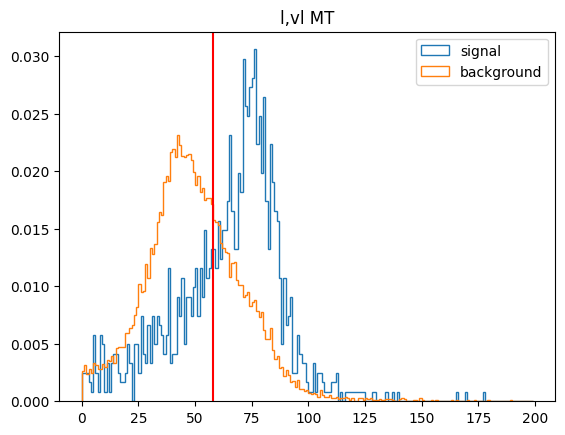

<Figure size 640x480 with 0 Axes>

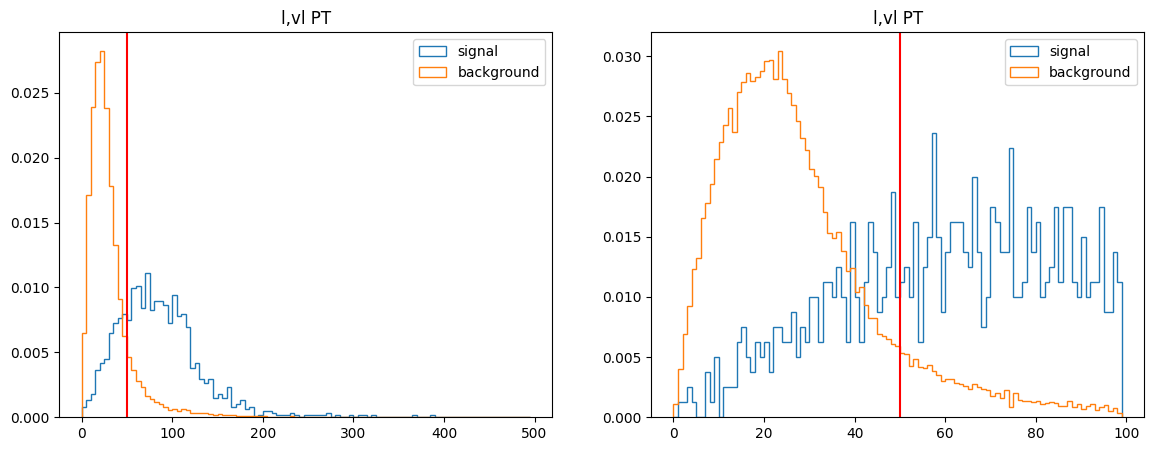

In [7]:

sg_MTvl=[]
bg_MTvl=[]
sg_PTvl=[]
bg_PTvl=[]
MTvl_sl(sgsl_2a_1l,sg_MTvl,sg_PTvl)
MTvl_sl(bgsl_2a_1l,bg_MTvl,bg_PTvl)


plt.figure(1)
bins=np.arange(0,200,1) 
plt.hist(sg_MTvl,bins=bins,histtype='step',label="signal",density='ture')
plt.hist(bg_MTvl,bins=bins,histtype='step',label="background",density='ture')
plt.axvline(58, color='r')
plt.title('l,vl MT')
plt.legend()
plt.show


plt.figure(2)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
bins=np.arange(0,500,5)
plt.hist(sg_PTvl,bins=bins,histtype='step',label="signal",density='ture')
plt.hist(bg_PTvl,bins=bins,histtype='step',label="background",density='ture')
plt.axvline(50, color='r')
plt.title('l,vl PT')
plt.legend()
plt.show

plt.subplot(1, 2, 2)
bins=np.arange(0,100,1)
plt.hist(sg_PTvl,bins=bins,histtype='step',label="signal",density='ture')
plt.hist(bg_PTvl,bins=bins,histtype='step',label="background",density='ture')
plt.axvline(50, color='r')
plt.title('l,vl PT')
plt.legend()
plt.show





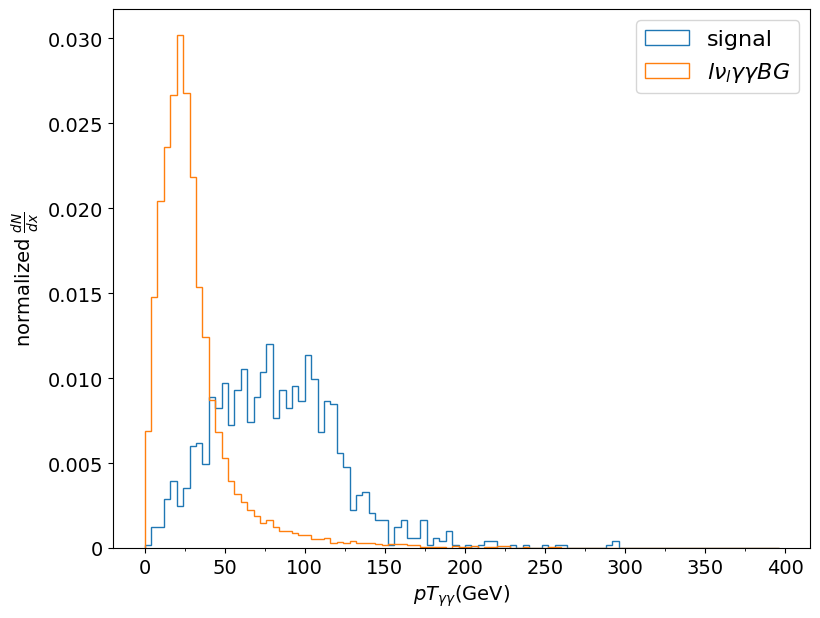

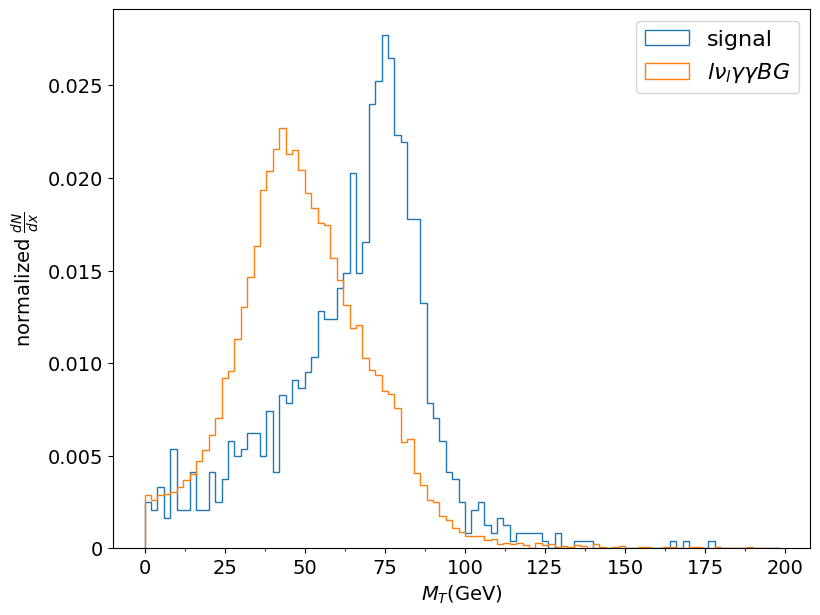

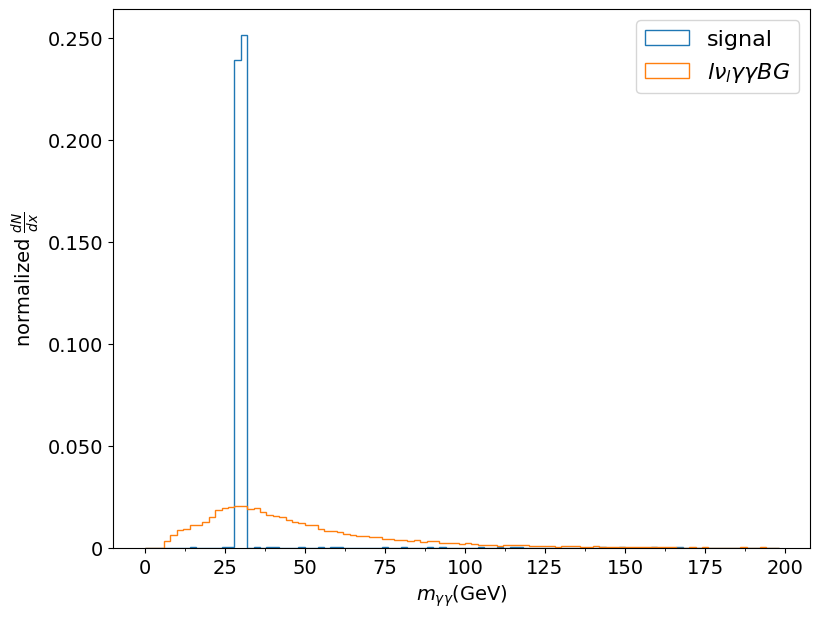

In [8]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter

#強制y刻度顯示5格
def custom_formatter(value, pos):
    # 直接处理数值为0的情况，只显示"0"
    if value == 0:
        return "0"
    elif abs(value) < 1:
        formatted_label = "{: >5.3f}".format(value)
    else:
        formatted_label = "{: >5.0f}".format(value)
    return formatted_label

#PTaa
fig, ax = plt.subplots(figsize=(9,7))
bins = np.arange(0, 400, 4)
ax.hist(pt_sgsl_2a_1l, bins=bins, label="signal", histtype='step', density=True)
ax.hist(pt_bgsl_2a_1l, bins=bins, label=r"$l\nu_{l}\gamma \gamma BG$", histtype='step', density=True)
ax.set_xlabel(r"$pT_{\gamma \gamma}$(GeV)", fontsize=14)
ax.set_ylabel(r"normalized $\frac{dN}{dx}$", fontsize=14)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.show()

#MT
fig, ax = plt.subplots(figsize=(9,7))
bins=np.arange(0,200,2)
ax.hist(sg_MTvl, bins=bins, label="signal", histtype='step', density=True)
ax.hist(bg_MTvl, bins=bins, label=r"$l\nu_{l}\gamma \gamma BG$", histtype='step', density=True)
ax.set_xlabel(r"$M_{T}$(GeV)", fontsize=14)
ax.set_ylabel(r"normalized $\frac{dN}{dx}$", fontsize=14)
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.xaxis.set_minor_locator(MultipleLocator(12.5))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.show()

#maa
fig, ax = plt.subplots(figsize=(9,7))
bins=np.arange(0,200,2)
ax.hist(maa_sgsl_2a_1l, bins=bins, label="signal", histtype='step', density=True)
ax.hist(maa_bgsl_2a_1l, bins=bins, label=r"$l\nu_{l}\gamma \gamma BG$", histtype='step', density=True)
ax.set_xlabel(r"$m_{\gamma \gamma}$(GeV)", fontsize=14)
ax.set_ylabel(r"normalized $\frac{dN}{dx}$", fontsize=14)
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.xaxis.set_minor_locator(MultipleLocator(12.5))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

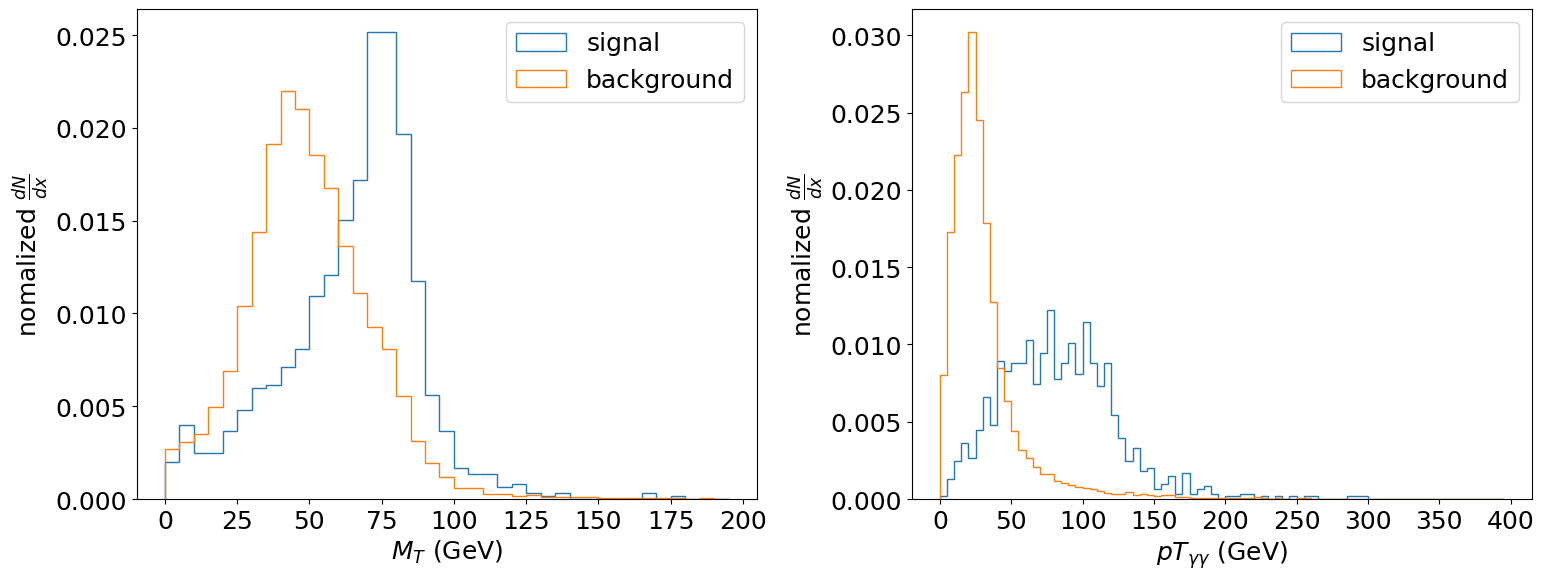

In [9]:


plt.figure(1, figsize=(18,14))
plt.subplots_adjust(wspace=0.25)

ax1 = plt.subplot(221)
bins=np.arange(0,200,5)
ax1.hist(sg_MTvl,bins=bins,histtype='step',label="signal",density='ture')
ax1.hist(bg_MTvl,bins=bins,histtype='step',label="background",density='ture')
plt.xlabel(r"$M_T\rm~(GeV)$", fontsize=18)
plt.ylabel(r"nomalized $\frac{dN}{dx}$", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.axvline(58, color='r')
plt.legend(loc='best', fontsize=18)
plt.show

# ax2 = plt.subplot(222)
# bins=np.arange(0,400,5)
# ax2.hist(sg_PTvl,bins=bins,histtype='step',label="signal",density='ture')
# ax2.hist(bg_PTvl,bins=bins,histtype='step',label="background",density='ture')
# plt.xlabel(r"$pT_{l \nu_l}\rm~(GeV)$", fontsize=18)
# plt.ylabel(r"nomalized $\frac{dN}{dx}$", fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# #plt.axvline(50, color='r')
# plt.legend(loc='best', fontsize=18)
# plt.show

ax3 = plt.subplot(222)
bins=np.arange(0,400,5)
ax3.hist(pt_sgsl_2a_1l, bins=bins, label="signal", histtype='step',density='ture')
ax3.hist(pt_bgsl_2a_1l, bins=bins, label="background", histtype='step',density='ture')
plt.xlabel(r"$pT_{\gamma \gamma}\rm~(GeV)$", fontsize=18)
plt.ylabel(r"nomalized $\frac{dN}{dx}$", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.axvline(50, color='r')
plt.legend(loc='best', fontsize=18)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

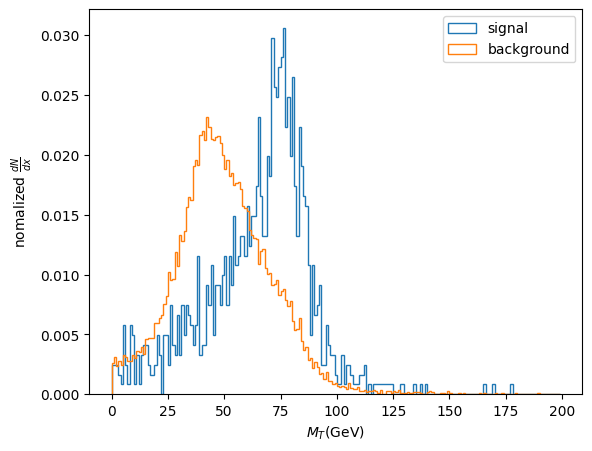

<Figure size 640x480 with 0 Axes>

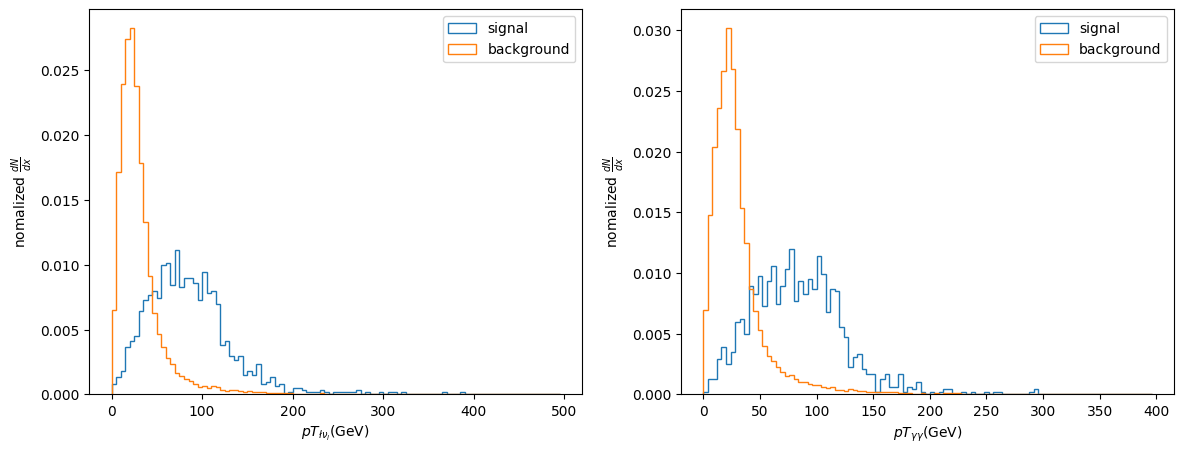

In [10]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)

bins=np.arange(0,200,1)
plt.hist(sg_MTvl,bins=bins,histtype='step',label="signal",density='ture')
plt.hist(bg_MTvl,bins=bins,histtype='step',label="background",density='ture')
plt.xlabel(r"$M_T$(GeV)")
plt.ylabel(r"nomalized $\frac{dN}{dx}$")
#plt.axvline(58, color='r')
plt.legend()
plt.show


plt.figure(2)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
bins=np.arange(0,500,5)
plt.hist(sg_PTvl,bins=bins,histtype='step',label="signal",density='ture')
plt.hist(bg_PTvl,bins=bins,histtype='step',label="background",density='ture')
plt.xlabel(r"$pT_{\l \nu_l}$(GeV)")
plt.ylabel(r"nomalized $\frac{dN}{dx}$")
#plt.axvline(50, color='r')
plt.legend()
plt.show

plt.subplot(1,2,2)
bins=np.arange(0,400,4)
plt.hist(pt_sgsl_2a_1l, bins=bins, label="signal", histtype='step',density='ture')
plt.hist(pt_bgsl_2a_1l, bins=bins, label="background", histtype='step',density='ture')
plt.xlabel(r"$pT_{\gamma \gamma}$(GeV)")
plt.ylabel(r"nomalized $\frac{dN}{dx}$")
#plt.axvline(50, color='r')
plt.legend()
plt.show

In [11]:
bgsl_event = len(bgsl_2a_1l_pt_PTsl_MTsl_msl)
sgsl_event = len(sgsl_2a_1l_pt_PTsl_MTsl_msl)
bgNsl_event = len(bg_events)
sgNsl_event = len(sg_events)

C_W = 2
C_B = 1
fa = 1000
sin_w_2 = 0.22290
cos_w_2 = 1 - sin_w_2

Lum = [300,3000]

for k in range(len(Lum)):
    
    s = sg_Xsection*(sgsl_event/sgNsl_event)*Lum[k]
    b = bg_Xsection*(bgsl_event/bgNsl_event)*Lum[k]

    for i in range(0,10000):
        if 1>significance(i,b)-2>0:
            max_n = i
#           print(significance(i,b))
            break
        
    max_n = max_n        
    min_n = max_n - 1
    
    exp_s = z_2(significance, min_n, max_n)  ###  exp_s=3 
    exp_sg_Xsection = (exp_s*sg_Xsection/s)

    print('\033[0;34mLuminosity:',Lum[k],'\033[0m')
    print('sg_Xsection:',sg_Xsection)
    print('z:',significance(s,b))
    print('exp_z:',significance(exp_s,b))
    print('exp_s:',exp_s)
    print('exp_sg_Xsection:',exp_sg_Xsection)

    fa_limit = fa*np.sqrt(sg_Xsection/exp_sg_Xsection)
    gaww_limt = (4*C_W)/fa_limit

    print('')
    print('fa_limit',fa_limit)
    print('gaww_limt',gaww_limt)
    print('******************************************************')
        
  


NameError: name 'bgsl_2a_1l_pt_PTsl_MTsl_msl' is not defined

In [ ]:
mass = [100,90,80,70,60,50,40,30,25]
Z_300    = [1025.5638121205477,1037.733628187837,1052.5616392767542,1072.5101401328188,1113.2507499611227,1169.4749979568778,1151.9549184628459,1099.5608310656248,997.0797787104248]
fa_300   = [125266.32308352285,125832.56099161801,127916.40467903014,130030.90091596507,137412.56146985627,150287.2150376816,151835.70228577525,148007.51924408844,137646.59503197134]
gaww_300 = [6.386393248459846e-05,6.357654916149166e-05,6.25408447030209e-05,6.152383736209096e-05,5.821884050793226e-05,5.323140759507823e-05,5.268853029666845e-05,5.4051307939339895e-05,5.8119853950196373e-05]

s_mass     = [25,20,15,10,5,1]
s_z_300    = [0,2037.4047685853936,2399.5290971657696,2300.317673482411,1928.2557490219497,27.22216381487182]
s_fa_300   = [272524.861251226,420761.96690554376,495457.8815237079,420315.9808172682,306310.1289139384,4439.622286799846]
s_gaww_300 = [2.935511998160502e-05,1.9013125304160174e-05,1.6146680269566356e-05,1.9033299624831513e-05,2.6117321122762148e-05,0.001801955095095834]
#####################################################

Z_3000 = [1747.0019219827561,1737.1090070783266,1771.844894688504,1795.176422026773,1943.033916328915,2204.943290035356,2259.4604948077927,2219.514468535124,2075.039356067173]
fa_3000 = [194074.81080822932,192739.8036690658,196661.53689533734,199170.4699956341,216255.11312160714,247782.82894505246,255923.21068563304,253316.79251726696,239290.74429857582]
gaww_3000 = [4.122121756390643e-05,4.1506735234285074e-05,4.067902715647735e-05,4.0166596986869405e-05,3.699334496429384e-05,3.2286337330396915e-05,3.1259376508162504e-05,3.15810093776341e-05,3.343213304572271e-05]

s_z_3000    = [0,5329.530620828865,6275.878881764145,5772.31663965786,4516.590618290388,27.247714532931386]
s_fa_3000   = [861799.2805752393,846021.7996530969,996212.1140884788,810166.7375227557,565207.8998336256,4442.446380746832]
s_gaww_3000 = [9.282904012939194e-06,9.456021113498876e-06,8.030418308373911e-06,9.87451055379239e-06,1.415408383774338e-05,0.0018008095797557152]
#####################################################
plt.figure(1)
plt.plot(mass,fa_300,label='Luminosity_300',color = 'blue')
plt.plot(mass,fa_3000,label='Luminosity_3000',color = 'orange')
plt.plot(s_mass,s_fa_300,label='Luminosity_300',color = 'blue')
plt.plot(s_mass,s_fa_3000,label='Luminosity_3000',color = 'orange')
plt.title('fa limit')
plt.xlabel('ALP mass')
plt.ylabel('fa')
plt.yscale("log")
plt.legend(loc='best')
plt.show


plt.figure(2)
plt.plot(mass,gaww_300,label='Luminosity_300',color = 'blue')
plt.plot(mass,gaww_3000,label='Luminosity_3000',color = 'orange')
plt.plot(s_mass,s_gaww_300,label='Luminosity_300',color = 'blue')
plt.plot(s_mass,s_gaww_3000,label='Luminosity_3000',color = 'orange')
plt.title('gaww limit')
plt.xlabel('ALP mass')
plt.ylabel('gaww')
plt.yscale("log")
plt.legend(loc='best')
plt.show


In [ ]:
df = pd.read_csv("/data/excel/test.csv")

mass_list = df["mass(GeV)"].to_list()
gaww_list = df["gaww(GeV^-1)"].to_list()
G_mass_list = df["G_mass(GeV)"].to_list()
G_gaww_list = df["G_gaww(GeV^-1)"].to_list()
T_mass_list = df["T_mass(GeV)"].to_list()
T_gaww_list = df["T_gaww(GeV^-1)"].to_list()
N_mass_list = df["N_mass(GeV)"].to_list()
N_gaww_list = df["N_gaww(GeV^-1)"].to_list()



plt.figure(1)
plt.plot(mass_list,gaww_list,color = 'green',label='photon(various)')
#plt.plot(G_mass_list,G_gaww_list,color = 'black',label='g.i.')
plt.plot(T_mass_list,T_gaww_list,color = 'black',label='LHC triboson 1811.05466')
plt.plot(N_mass_list,N_gaww_list,color = 'yellow',label='Nonresonant ggF (LHC)')

plt.plot(mass,gaww_300,label='Luminosity_300',color = 'blue')
plt.plot(mass,gaww_3000,label='Luminosity_3000',color = 'orange')
plt.plot(s_mass,s_gaww_300,color = 'blue')
plt.plot(s_mass,s_gaww_3000,color = 'orange')

plt.title('gaww limit')
plt.xlabel('ALP mass')
plt.ylabel('gaww')
plt.xscale("log")
plt.yscale("log")
plt.xlim(1,100) #
plt.legend(loc='best')
plt.show

In [ ]:
mass = [100,90,80,70,60,50,40]
Z = []
fa = [21075.0191600583,25331.3962568524,39468.5955278287,85780.6109734748,295301.583636572,315124.177196493,289543.979815956]
gaww = [0.000379596333424061,0.000315813621913395,0.000202692796462932,0.000093261168336441,0.0000270909485194146,0.0000253868175751289,0.0000276296540687361]

plt.figure(1)
x = mass
y = fa
plt.plot(x,y)
plt.title('fa limit')
plt.xlabel('ALP mass')
plt.ylabel('fa')
plt.yscale("log")
plt.show


plt.figure(2)
x = mass
y = gaww
plt.plot(x,y)
plt.title('fa limit')
plt.xlabel('ALP mass')
plt.ylabel('gaww')
plt.yscale("log")
plt.show



In [ ]:
sg_mvl=[]
bg_mvl=[]
mvl_sl(sgsl_2a_1l,sg_mvl)
mvl_sl(bgsl_2a_1l,bg_mvl)

bins=np.arange(0,1000,8) 
plt.hist(sg_mvl,bins=bins,histtype='step',label="signal")
plt.hist(bg_mvl,bins=bins,histtype='step',label="background")
#plt.axvline(80, color='r')
plt.legend()
plt.show


In [ ]:

phi1=[]
plt.figure(1)
phi_v(sgsl_2a_1l_pt_msl,phi1)
bins=np.arange(-3,3,0.1)
plt.hist(phi1,bins=bins)
plt.show

phi2=[]
plt.figure(2)
miss_v(sgsl_2a_1l_pt_msl,phi2)
bins=np.arange(-2.5,2.5,0.1)
plt.hist(phi2,bins=bins)
plt.show




In [ ]:
jet_num = []
num = []

jetlen = num_sl(sg_events,18,1)
prlen(jetlen)

for i in range(len(sg_events)):
    jet_num.append(sg_events[i][18])

jetmax=np.max(jet_num)

for i in range(jetmax):
    num.append(i)
  
plt.hist(jet_num,histtype='step')
for i in range(len(num)):
    plt.text(x=num[i], y=len(num_sl(sg_events,18,i)), s=str(len(num_sl(sg_events,18,i))), ha='left', va='bottom')

plt.show


In [ ]:
headover = []

def slend(x):
    return x<0.02

for i in range(len(sg_events)):
    for j in range(sg_events[i][18]):
        headover.append(sg_events[i][19][j])

bins=np.arange(0,1,0.01)
plt.hist(headover,bins=bins,histtype='step',label="signal")
plt.show

prlen(num_sl(sg_events,8,2))

b=filter(slend,headover)
print(len(list(b)))

In [ ]:
jmass=[]

for i in range(len(sg_events)):
    for j in range(sg_events[i][18]):
        jmass.append(sg_events[i][20][j])

bins=np.arange(0,200,1)
plt.hist(jmass,bins=bins,histtype='step',label="signal")
plt.show